##Import Required Libraries

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##Loading and Analyzing

In [70]:
data = pd.read_csv("AirlineTwitterData.csv", encoding = "ISO-8859-1")

In [71]:
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada)
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada)


In [72]:
df = data[['text', 'airline_sentiment']].copy()

In [73]:
df.rename(columns = {"text" : "tweet", "airline_sentiment" : "sentiment"}, inplace = True)

In [74]:
df.isnull().sum()

,0
tweet,0
sentiment,0


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      14640 non-null  object
 1   sentiment  14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


##Data Preprocessing

In [76]:
le = LabelEncoder()
df.sentiment = le.fit_transform(df.sentiment)

In [77]:
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(label_mapping)

{'negative': 0, 'neutral': 1, 'positive': 2}


In [78]:
value_count = df.sentiment.value_counts()
print(value_count)

sentiment
0    9178
1    3099
2    2363
Name: count, dtype: int64


In [79]:
stop_words = set(stopwords.words('english'))

In [80]:
df['clean_tweet'] = df['tweet'].apply(lambda x : ' '.join([word for word in x.split() if word.lower() not in stop_words]))

In [81]:
def clean_text(text):
    text = re.sub(r'@\w+|#\w+|https?://(?:www\.)?[^\s/$.?#].[^\s]*', '', text)  # Remove mentions, hashtags, and URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)  # Remove non-alphanumeric characters
    return text.strip().lower()  # Strip whitespace and convert to lowercase

# Apply the cleaning function to the DataFrame
df['clean_tweet'] = df['clean_tweet'].apply(clean_text)

In [82]:
df.drop('tweet', axis = 1, inplace = True)

In [83]:
df.head()

,sentiment,clean_tweet
0,1,said
1,2,plus added commercials experience tacky
2,1,today must mean need take another trip
3,0,really aggressive blast obnoxious entertainmen...
4,0,really big bad thing


In [84]:
Tfidf = TfidfVectorizer(max_features = 5000, ngram_range=(1,2))
X = Tfidf.fit_transform(df.clean_tweet).toarray()
y = df['sentiment']

In [85]:
# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [86]:
unique_values, counts = np.unique(y_res, return_counts=True)

value_counts = dict(zip(unique_values, counts))
print(value_counts)

{0: 9178, 1: 9178, 2: 9178}


##Model Building

In [87]:
X_test, X_train, y_test, y_train = train_test_split(X_res,y_res, test_size = 0.3, random_state = 42)

###Multinomial Naive Bayes

In [88]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
nb_acc = accuracy_score(y_test, y_pred)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.81      0.67      0.73      7708
           1       0.61      0.76      0.67      5206
           2       0.81      0.82      0.81      6359

    accuracy                           0.74     19273
   macro avg       0.74      0.75      0.74     19273
weighted avg       0.75      0.74      0.74     19273



###Logistic Regresion

In [89]:
lr = LogisticRegression(max_iter = 1000)
lr.fit(X_train, y_train)
y_pred = nb.predict(X_test)
lr_acc = accuracy_score(y_test, y_pred)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.81      0.67      0.73      7708
           1       0.61      0.76      0.67      5206
           2       0.81      0.82      0.81      6359

    accuracy                           0.74     19273
   macro avg       0.74      0.75      0.74     19273
weighted avg       0.75      0.74      0.74     19273



###XGBoost

In [90]:
xgb = XGBClassifier(eval_metric='mlogloss')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, y_pred)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      5892
           1       0.79      0.68      0.73      7531
           2       0.76      0.84      0.80      5850

    accuracy                           0.77     19273
   macro avg       0.77      0.78      0.77     19273
weighted avg       0.77      0.77      0.77     19273



###Random Forest Classifier

In [91]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      6165
           1       0.79      0.76      0.78      6678
           2       0.84      0.84      0.84      6430

    accuracy                           0.81     19273
   macro avg       0.81      0.81      0.81     19273
weighted avg       0.81      0.81      0.81     19273



###K-Nearest Neighbour

In [92]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test, y_pred)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.01      0.90      0.02        86
           1       0.76      0.50      0.61      9750
           2       0.81      0.56      0.66      9437

    accuracy                           0.53     19273
   macro avg       0.53      0.65      0.43     19273
weighted avg       0.78      0.53      0.63     19273



Decision Tree Classifier

In [93]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
dt_acc = accuracy_score(y_test, y_pred)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72      6074
           1       0.72      0.68      0.70      6827
           2       0.78      0.79      0.78      6372

    accuracy                           0.73     19273
   macro avg       0.73      0.74      0.73     19273
weighted avg       0.73      0.73      0.73     19273



##Model Accuracy Comparison

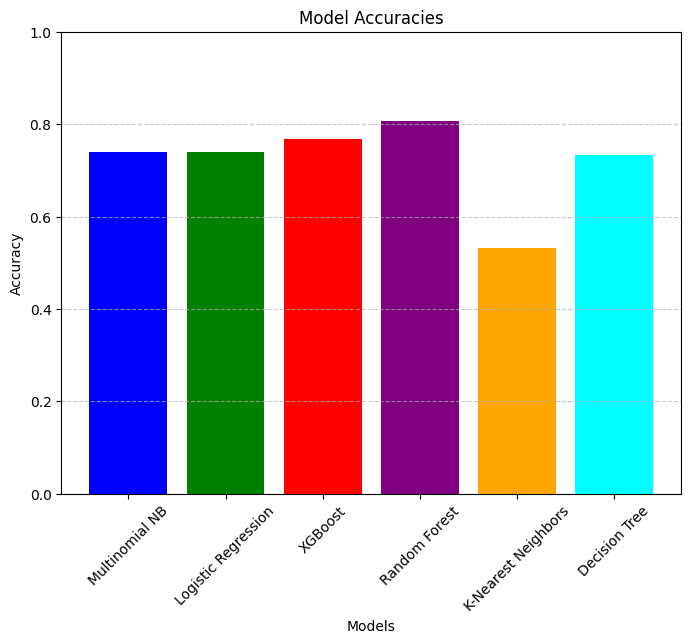

In [107]:
models = ['Multinomial NB', 'Logistic Regression', 'XGBoost', 'Random Forest', 'K-Nearest Neighbors', 'Decision Tree']
accuracies = [nb_acc, lr_acc, xgb_acc, rf_acc, knn_acc, dt_acc]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.ylim([0, 1])  # Assuming accuracy is between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Display the plot
plt.show()